In [1]:
import sys; sys.path.append('/home/clair/wwa'); from wwa import *
from scipy.stats import pearsonr, spearmanr

cproj = cartopy.crs.PlateCarree()

In [3]:
def read_psl(fnm, vnm = "tpi"):
    
    ys, ye = pd.read_csv(fnm, nrows = 0, sep = " +", engine = "python").columns.to_list()

    df = pd.DataFrame(pd.read_csv(fnm, skiprows = 1, nrows = int(ye) - int(ys) + 1, header = None, sep = " +", engine = "python", index_col = 0).values.flatten(), 
                         index = pd.date_range(start = ys+"-01", end = ye+"-12", freq = "MS"), columns = [vnm])
    df = df[df > -90].dropna(axis = 0, how = "any")
    return df

---
## **Create dataframes**

In [390]:
pr = xr.open_dataset("data/HawkesBayGisborneDailyRainfallV_c_5.nc").precipitation_amount.rename("pr")
pr_notc = xr.open_dataset("data/HawkesBayGisborneDailyRainfall_C_noTC.nc").precipitation_amount.rename("pr")

ipo = read_psl("data/tpi.timeseries.ersstv5.data.txt", vnm = "ipo").loc[slice("1935", None)]
nino34 = decode_times(xr.open_dataset("data/iersst_nino3.4a_rel.nc", decode_times = False))["Nino3.4r"].dropna("time", "any").resample(time = "MS").mean().rename("nino34").to_dataframe()
pdo = decode_times(xr.open_dataset("data/ipdo_ersst.nc", decode_times = False)).index.dropna("time", "any").resample(time = "MS").mean().rename("pdo").to_dataframe()

# nb. GMST is Jan-Dec mean so this should be recalculated using Jul-Jun, if this is the approach we eventually take
gmst = pd.read_fwf("../../Data/gmst.dat", comment = "#", widths = [5,15], header = None, names = ["year", "gmst"], index_col = 0)
gmst = gmst - gmst.loc[2023]
gmst = gmst.loc[slice("1936", "2023")]

rx2day_jj = pr.rolling(time = 2, center = False).sum().resample(time = "AS-JUL").max().rename("rx2day").to_dataframe()
rx2day_jj_notc = pr_notc.rolling(time = 2, center = False).sum().resample(time = "AS-JUL").max().rename("rx2day_notc").to_dataframe()

df = merge_byindex([rx2day_jj, rx2day_jj_notc] + [ts.resample("AS-JUL").mean() for ts in [ipo, nino34, pdo]])

df.index = df.index.year+1  # label as end of period (eg '2023' denotes July 2022-June 2023)
df.index.names = ['year']
df = df.loc[slice("1936", "2023")]
df = merge_byindex([df, gmst])
df.to_csv("ts/rx2day-jj_composite.csv")

---
## **Interdecadal Pacific oscillation**

Time series downloaded from https://psl.noaa.gov/data/timeseries/IPOTPI/

In [123]:
cobe, cobe_f, ersst, ersst_f = [read_psl(fnm, vnm = re.sub(".data.txt", "", re.sub("tpi.timeseries.", "", fnm))).loc[slice("1935", None)] for fnm in sorted(glob.glob("data/tpi*"))]

<AxesSubplot: >

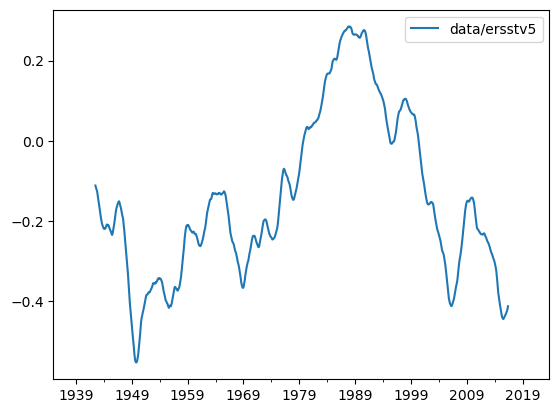

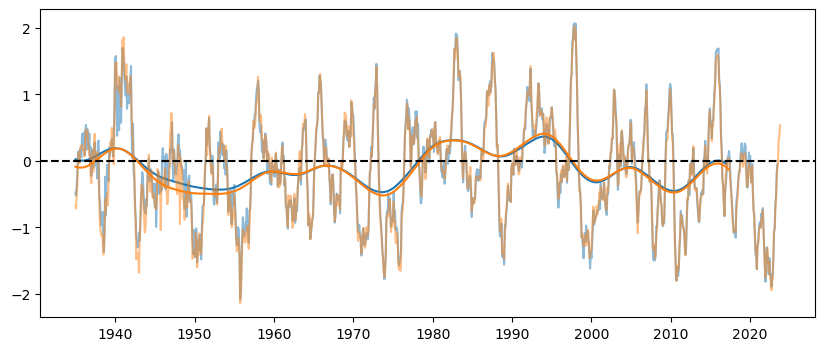

In [135]:
fig = plt.figure(figsize = (10,4))
plt.plot(cobe, color = "tab:blue", alpha = 0.5)
plt.plot(cobe_f, color = "tab:blue")
plt.plot(ersst, color = "tab:orange", alpha = 0.5)
plt.plot(ersst_f, color = "tab:orange")
plt.axhline(0, color = "k", ls = "--")

### **Correlation with ENSO, PDO & precipitation**

In [86]:
ipo = read_psl("data/tpi.timeseries.ersstv5.data.txt", vnm = "ipo").loc[slice("1935", None)]
nino34 = decode_times(xr.open_dataset("data/iersst_nino3.4a_rel.nc", decode_times = False))["Nino3.4r"].dropna("time", "any").resample(time = "MS").mean().rename("nino34").to_dataframe()
pdo = decode_times(xr.open_dataset("data/ipdo_ersst.nc", decode_times = False)).index.dropna("time", "any").resample(time = "MS").mean().rename("pdo").to_dataframe()
pr_monthly = xr.open_dataset("data/HawkesBayGisborneDailyRainfallV_c_5.nc").precipitation_amount.resample(time = "MS").sum().rename("pr_monthly").to_dataframe()
pr_2daymax = xr.open_dataset("data/HawkesBayGisborneDailyRainfallV_c_5.nc").precipitation_amount.rolling(time = 2).sum().resample(time = "MS").max().rename("pr_2daymax").to_dataframe()

df = merge_byindex([ipo, nino34, pdo, pr_monthly, pr_2daymax])

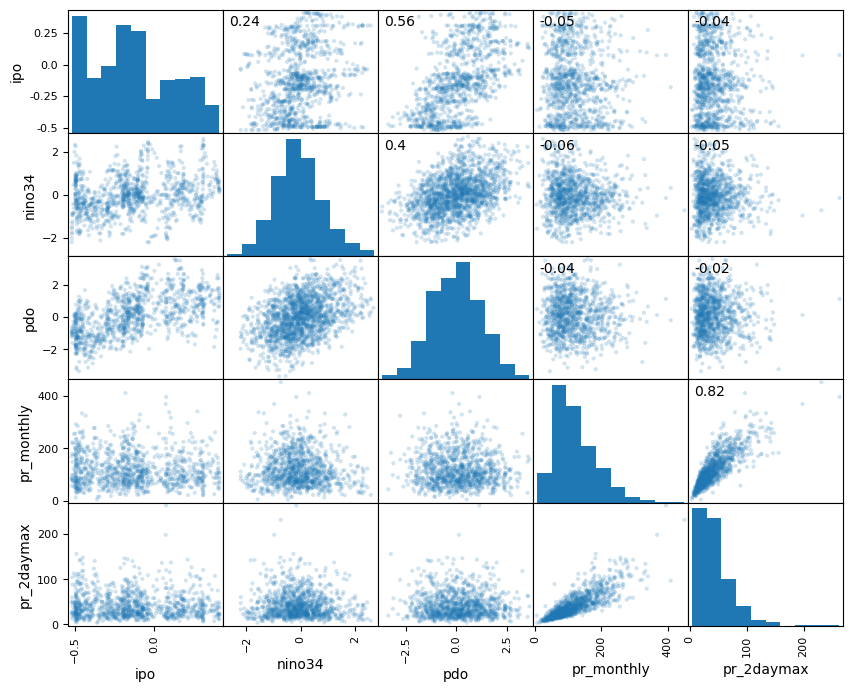

In [85]:
axes = pd.plotting.scatter_matrix(df, alpha=0.2, figsize = (10,8))

corr = df.corr().to_numpy().round(2)
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate(corr[i,j], (0.04, 0.9), xycoords='axes fraction', ha='left', va='center')
    
plt.savefig("fig/correlations-monthly.png")

In [391]:
# ax = axs[1]
df.loc[slice("2000",None)].plot()
plt.axhline(0, color = "k", ls = "--")
plt.ylim(-3.5,3.5)

### **Correlation between annual time series**

In [398]:
df = pd.read_csv("ts/rx2day-jj_composite.csv", index_col = "year")

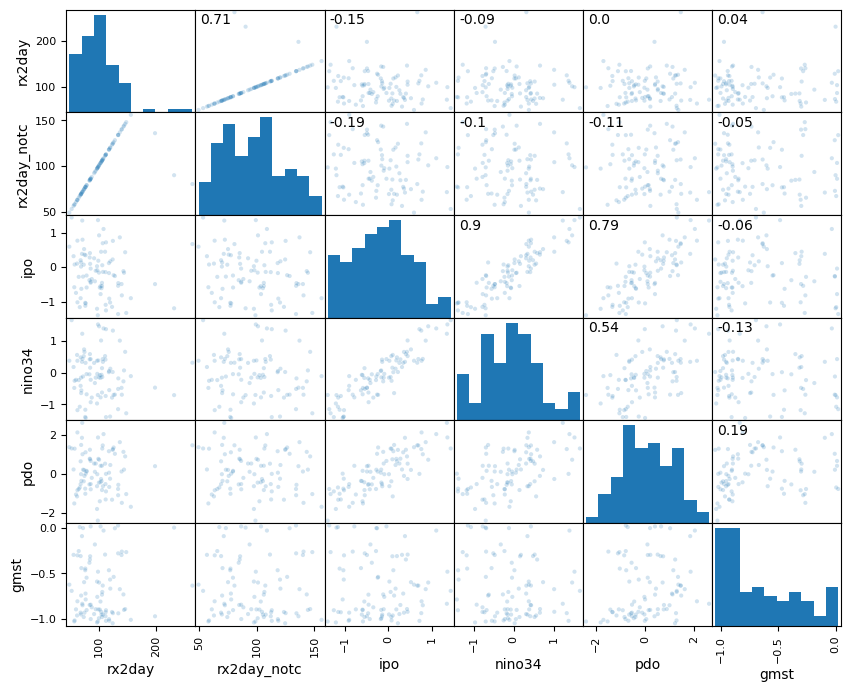

In [399]:
axes = pd.plotting.scatter_matrix(df, alpha=0.2, figsize = (10,8))

corr = df.corr().to_numpy().round(2)
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate(corr[i,j], (0.04, 0.9), xycoords='axes fraction', ha='left', va='center')
    
# weak correlation between RX2day and yearly IPO
plt.savefig("fig/correlations-rx2day.png")

### **Relationship between precip & smoothed IPO**

In [121]:
# load data & save as .csv for easier use later on
ipo = read_psl("data/tpi.timeseries.ersstv5.filt.data.txt", vnm = "ipo")
ipo.to_csv("ts/ipo-filt_monthly_ersstv5.csv")
ipo.resample("AS-JUL").mean().to_csv("ts/ipo-filt_annual_ersstv5.csv")

pr = xr.open_dataset("data/HawkesBayGisborneDailyRainfallV_21c.nc").precipitation_amount.rename("pr")
pr.assign_coords(time = pr.time.dt.strftime("%Y-%m-%d")).to_pandas().to_csv("ts/pr_xcomposite_withTC.csv")
rx2day = pr.rolling(time = 2).sum().resample(time = "AS-JUL").max().rename(time = "year").to_pandas().to_csv("ts/rx2day_xcomposite_withTC.csv")

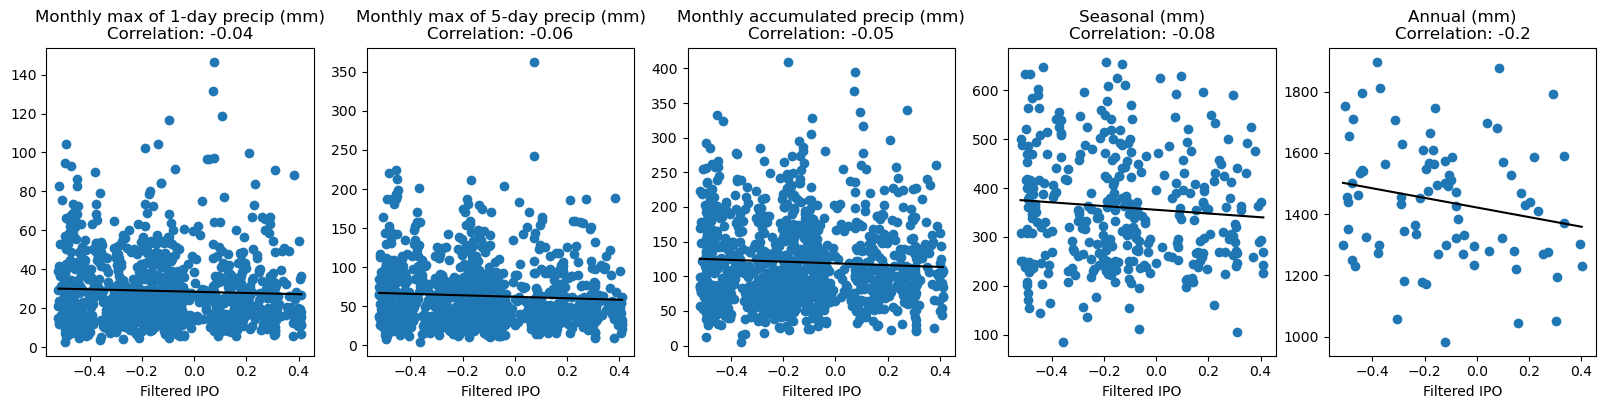

In [122]:
# load data & save as .csv for easier use later on
ipo = read_psl("data/tpi.timeseries.ersstv5.filt.data.txt", vnm = "ipo")
ipo = ipo.loc[slice("1935",None)]

pr = xr.open_dataset("data/HawkesBayGisborneDailyRainfallV_21c.nc").precipitation_amount.rename("pr")
fig, axs = plt.subplots(ncols = 5, figsize = (20,4), dpi = 100, sharex = True)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[0]
df = pd.merge(ipo, pr.resample(time = "MS").max().to_dataframe(), left_index = True, right_index = True, how = "inner")
ax.set_title("Monthly max of 1-day precip (mm)\nCorrelation: "+str(round(df.corr()["pr"][0], 2)))
ax.scatter(df.ipo, df.pr)
xyline(df.ipo, df.pr, ax = ax, color = "k")
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[1]
df = pd.merge(ipo, pr.rolling(time = 5).sum().resample(time = "MS").max().to_dataframe(), left_index = True, right_index = True, how = "inner")
ax.set_title("Monthly max of 5-day precip (mm)\nCorrelation: "+str(round(df.corr()["pr"][0], 2)))
ax.scatter(df.ipo, df.pr)
xyline(df.ipo, df.pr, ax = ax, color = "k")
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[2]
df = pd.merge(ipo, pr.resample(time = "MS").sum().to_dataframe(), left_index = True, right_index = True, how = "inner")
ax.set_title("Monthly accumulated precip (mm)\nCorrelation: "+str(round(df.corr()["pr"][0], 2)))
ax.scatter(df.ipo, df.pr)
xyline(df.ipo, df.pr, ax = ax, color = "k")
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[3]
df = pd.merge(ipo.resample("QS-DEC").mean(), pr.resample(time = "QS-DEC").sum().to_dataframe(), left_index = True, right_index = True, how = "inner")
ax.set_title("Seasonal (mm)\nCorrelation: "+str(round(df.corr()["pr"][0], 2)))
ax.scatter(df.ipo, df.pr)
xyline(df.ipo, df.pr, ax = ax, color = "k")
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[4]
df = pd.merge(ipo.resample("AS-DEC").mean(), pr.resample(time = "AS-DEC").sum().to_dataframe(), left_index = True, right_index = True, how = "inner")
ax.set_title("Annual (mm)\nCorrelation: "+str(round(df.corr()["pr"][0], 2)))
ax.scatter(df.ipo, df.pr)
xyline(df.ipo, df.pr, ax = ax, color = "k")
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for ax in axs: ax.set_xlabel("Filtered IPO")

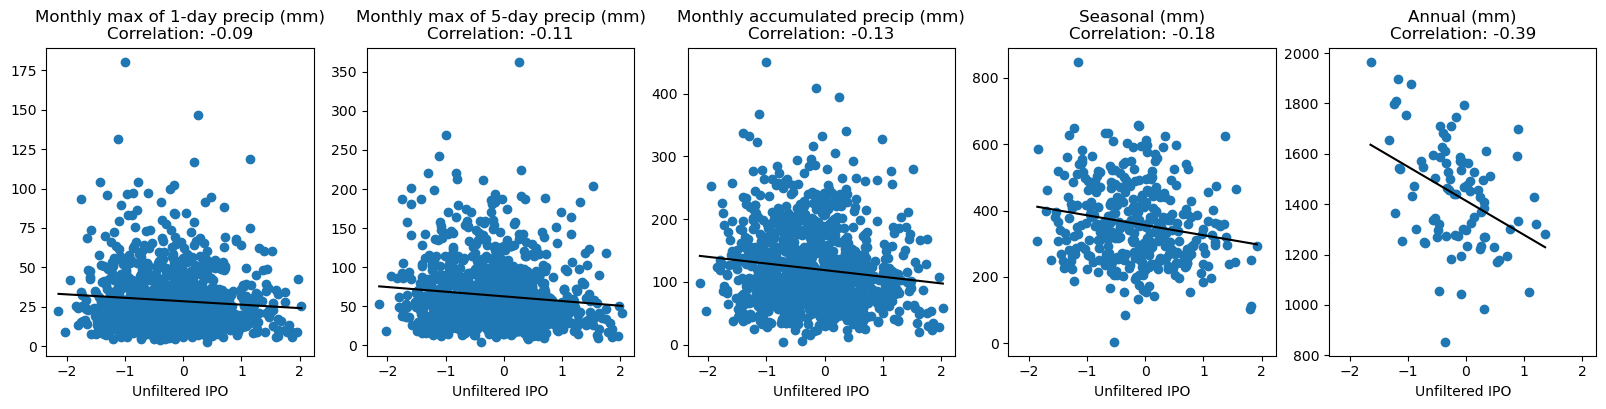

In [112]:
# load data & save as .csv for easier use later on
ipo = read_psl("data/tpi.timeseries.ersstv5.data.txt", vnm = "ipo")
ipo.to_csv("ts/ipo-filt_monthly_ersstv5.csv")
ipo = ipo.loc[slice("1935",None)]

pr = xr.open_dataset("data/HawkesBayGisborneDailyRainfallV_21c.nc").precipitation_amount.rename("pr")
pr.assign_coords(time = pr.time.dt.strftime("%Y-%m-%d")).to_pandas().to_csv("ts/pr_composite_withTC.csv")

fig, axs = plt.subplots(ncols = 5, figsize = (20,4), dpi = 100, sharex = True)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[0]
df = pd.merge(ipo, pr.resample(time = "MS").max().to_dataframe(), left_index = True, right_index = True, how = "inner")
ax.set_title("Monthly max of 1-day precip (mm)\nCorrelation: "+str(round(df.corr()["pr"][0], 2)))
ax.scatter(df.ipo, df.pr)
xyline(df.ipo, df.pr, ax = ax, color = "k")
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[1]
df = pd.merge(ipo, pr.rolling(time = 5).sum().resample(time = "MS").max().to_dataframe(), left_index = True, right_index = True, how = "inner")
ax.set_title("Monthly max of 5-day precip (mm)\nCorrelation: "+str(round(df.corr()["pr"][0], 2)))
ax.scatter(df.ipo, df.pr)
xyline(df.ipo, df.pr, ax = ax, color = "k")
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[2]
df = pd.merge(ipo, pr.resample(time = "MS").sum().to_dataframe(), left_index = True, right_index = True, how = "inner")
ax.set_title("Monthly accumulated precip (mm)\nCorrelation: "+str(round(df.corr()["pr"][0], 2)))
ax.scatter(df.ipo, df.pr)
xyline(df.ipo, df.pr, ax = ax, color = "k")
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[3]
df = pd.merge(ipo.resample("QS-DEC").mean(), pr.resample(time = "QS-DEC").sum().to_dataframe(), left_index = True, right_index = True, how = "inner")
ax.set_title("Seasonal (mm)\nCorrelation: "+str(round(df.corr()["pr"][0], 2)))
ax.scatter(df.ipo, df.pr)
xyline(df.ipo, df.pr, ax = ax, color = "k")
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[4]
df = pd.merge(ipo.resample("AS-DEC").mean(), pr.resample(time = "AS-DEC").sum().to_dataframe(), left_index = True, right_index = True, how = "inner")
ax.set_title("Annual (mm)\nCorrelation: "+str(round(df.corr()["pr"][0], 2)))
ax.scatter(df.ipo, df.pr)
xyline(df.ipo, df.pr, ax = ax, color = "k")
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for ax in axs: ax.set_xlabel("Unfiltered IPO")

## **Seasonal cycle of precip**

In [330]:
pr = xr.open_dataset("data/HawkesBayGisborneDailyRainfallV_c_5.nc").precipitation_amount.rename("pr")

days = pd.date_range(start = "2020-01-01", end = "2020-12-31")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[:1] for i in range(366) if (days[i].day) == 1]

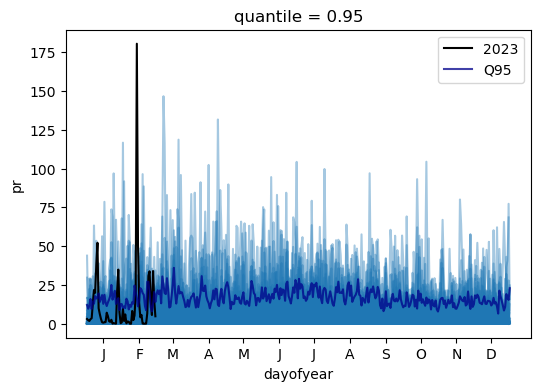

In [216]:
fig, ax = plt.subplots(figsize = (6,4), dpi = 100)

for y in range(1935,2023):
    ts_y = pr.sel(time = str(y))
    ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.4)
    
y = 2023
ts_y = pr.sel(time = str(y))
ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "k", alpha = 1, label = "2023")

# pr.groupby("time.dayofyear").mean().plot(ax = ax, color = "darkblue", label = "Mean", alpha = 0.75)
pr.groupby("time.dayofyear").quantile(0.95).plot(ax = ax, color = "darkblue", label = "Q95", alpha = 0.75)

ax.set_xticks(labelticks)
ax.set_xticklabels(labels)

ax.legend()

### **When do the wettest 2-day periods occur?**

In [199]:
pr_dates = xr.concat([pr.rolling(time = 2, center = False).sum().sel(time = slice(str(y)+"-07", str(y+1)+"-06")).idxmax("time").assign_coords(time = str(y)) for y in range(1935,2023)], "time")

days = pd.date_range(start = "2020-01-01", end = "2020-12-31")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[:1] for i in range(366) if (days[i].day) == 1]

[Text(5, 0, '1940'),
 Text(15, 0, '1950'),
 Text(25, 0, '1960'),
 Text(35, 0, '1970'),
 Text(45, 0, '1980'),
 Text(55, 0, '1990'),
 Text(65, 0, '2000'),
 Text(75, 0, '2010'),
 Text(85, 0, '2020')]

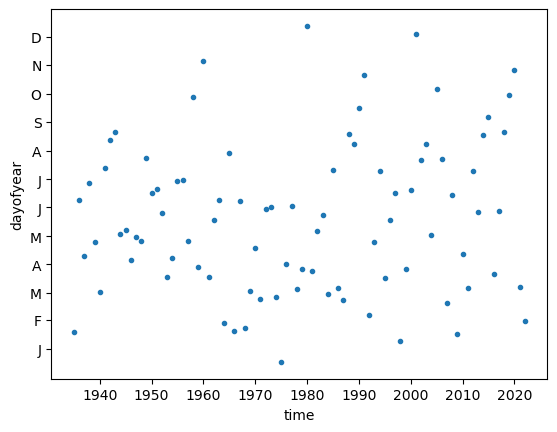

In [243]:
pr_dates.dt.dayofyear.plot(ls = "", marker = ".")
ax = plt.gca()
ax.set_yticks(labelticks)
ax.set_yticklabels(labels)

ax.set_xticks([i for i in range(len(pr_dates)) if pr_dates.time.values[i][-1] == "0"])
ax.set_xticklabels([pr_dates.time.values[i]for i in range(len(pr_dates)) if pr_dates.time.values[i][-1] == "0"])

In [379]:
pr = xr.open_dataset("data/HawkesBayGisborneDailyRainfallV_c_5.nc").precipitation_amount.rename("pr")
pr_notc = xr.open_dataset("data/HawkesBayGisborneDailyRainfall_C_noTC.nc").precipitation_amount.rename("pr")

ts = [pr.rolling(time = 2, center = False).sum().groupby("time.season")[s].resample(time = "AS-JUL").max().expand_dims(season = [s]) for s in ["DJF", "MAM", "JJA", "SON"]]
ts = xr.concat([da.assign_coords(time = da.time.dt.year) for da in ts], "season")

ts_notc = [pr_notc.rolling(time = 2, center = False).sum().groupby("time.season")[s].resample(time = "AS-JUL").max().expand_dims(season = [s]) for s in ["DJF", "MAM", "JJA", "SON"]]
ts_notc = xr.concat([da.assign_coords(time = da.time.dt.year) for da in ts_notc], "season")


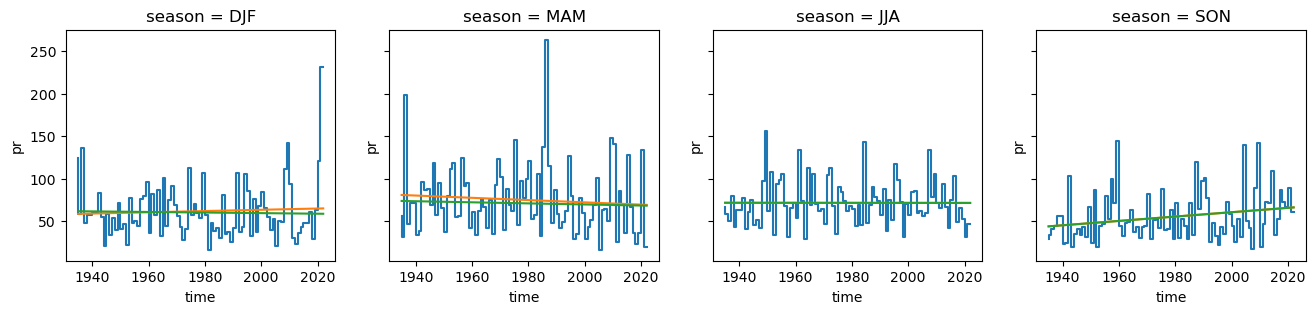

In [382]:
fig, axs = plt.subplots(ncols = 4, figsize = (16,3), dpi = 100, sharey = True)

for i in range(4):
    ax = axs[i]
    s = ["DJF", "MAM", "JJA", "SON"][i]
    
    ts.sel(season = s).plot(ax = ax, drawstyle = "steps")
    xyline(ts.time, ts.sel(season = s), ax = ax)
     
    xyline(ts_notc.time, ts_notc.sel(season = s), ax = ax)

(0.0, 275.0)

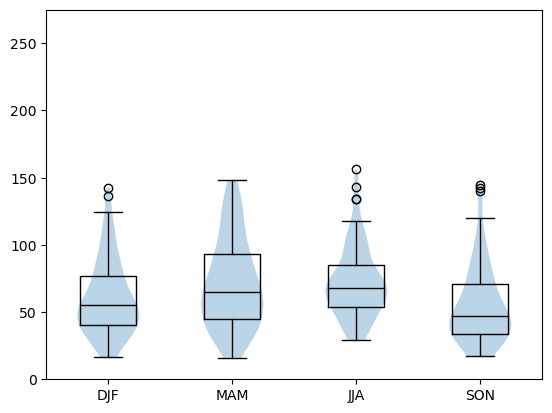

In [388]:
plt.violinplot(ts_notc.transpose(), showextrema = False)
plt.boxplot(ts_notc.transpose(), labels = ts_notc.season.values, medianprops = {"color" : "k"})
plt.title("")
plt.ylim(0,275)